In [7]:
import os
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import soundfile as sf
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


# Model 1 Normal And Abnormal Voice detection

In [8]:
# Mount Google Drive|
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# : Data Preparation & Exploration


Output directory initialized at: /content/drive/MyDrive/ProcessedData

STEP 1: Scanning Audio Files
Main folder path: /content/drive/MyDrive/SpeechRecognition/MozillaVoices
✅ Main folder exists
Contents of main folder:
  - Abnormal Voices (folder)
  - Normal Voices (folder)

--- Scanning normal folder ---
✅ Normal folder found: /content/drive/MyDrive/SpeechRecognition/MozillaVoices/Normal Voices
  Found 5017 new .mp3 files (including subfolders)
  Found 0 new .wav files (including subfolders)
  Found 0 new .flac files (including subfolders)

--- Scanning abnormal folder ---
✅ Abnormal folder found: /content/drive/MyDrive/SpeechRecognition/MozillaVoices/Abnormal Voices
  Found 0 new .mp3 files (including subfolders)
  Found 7207 new .wav files (including subfolders)
  Found 0 new .flac files (including subfolders)

📊 FINAL SCAN RESULTS:
Found 5017 total normal voice files
Found 7207 total abnormal voice files

STEP 2: Creating Dataset Catalog (CSV)
Found 7207 abnormal files.
Selected 51

Processing Abnormal Files: 100%|██████████| 5100/5100 [00:01<00:00, 3067.27it/s]


✅ Dataset catalog saved to: /content/drive/MyDrive/ProcessedData/dataset_catalog.csv (Total rows: 10117)

STEP 3: Analyzing Audio Properties from 100 Samples


Analyzing Audio Features: 100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


✅ Audio properties saved to: /content/drive/MyDrive/ProcessedData/audio_properties.csv

STEP 4: Generating Visualizations
✅ Analysis plots saved to: /content/drive/MyDrive/ProcessedData/data_analysis.png


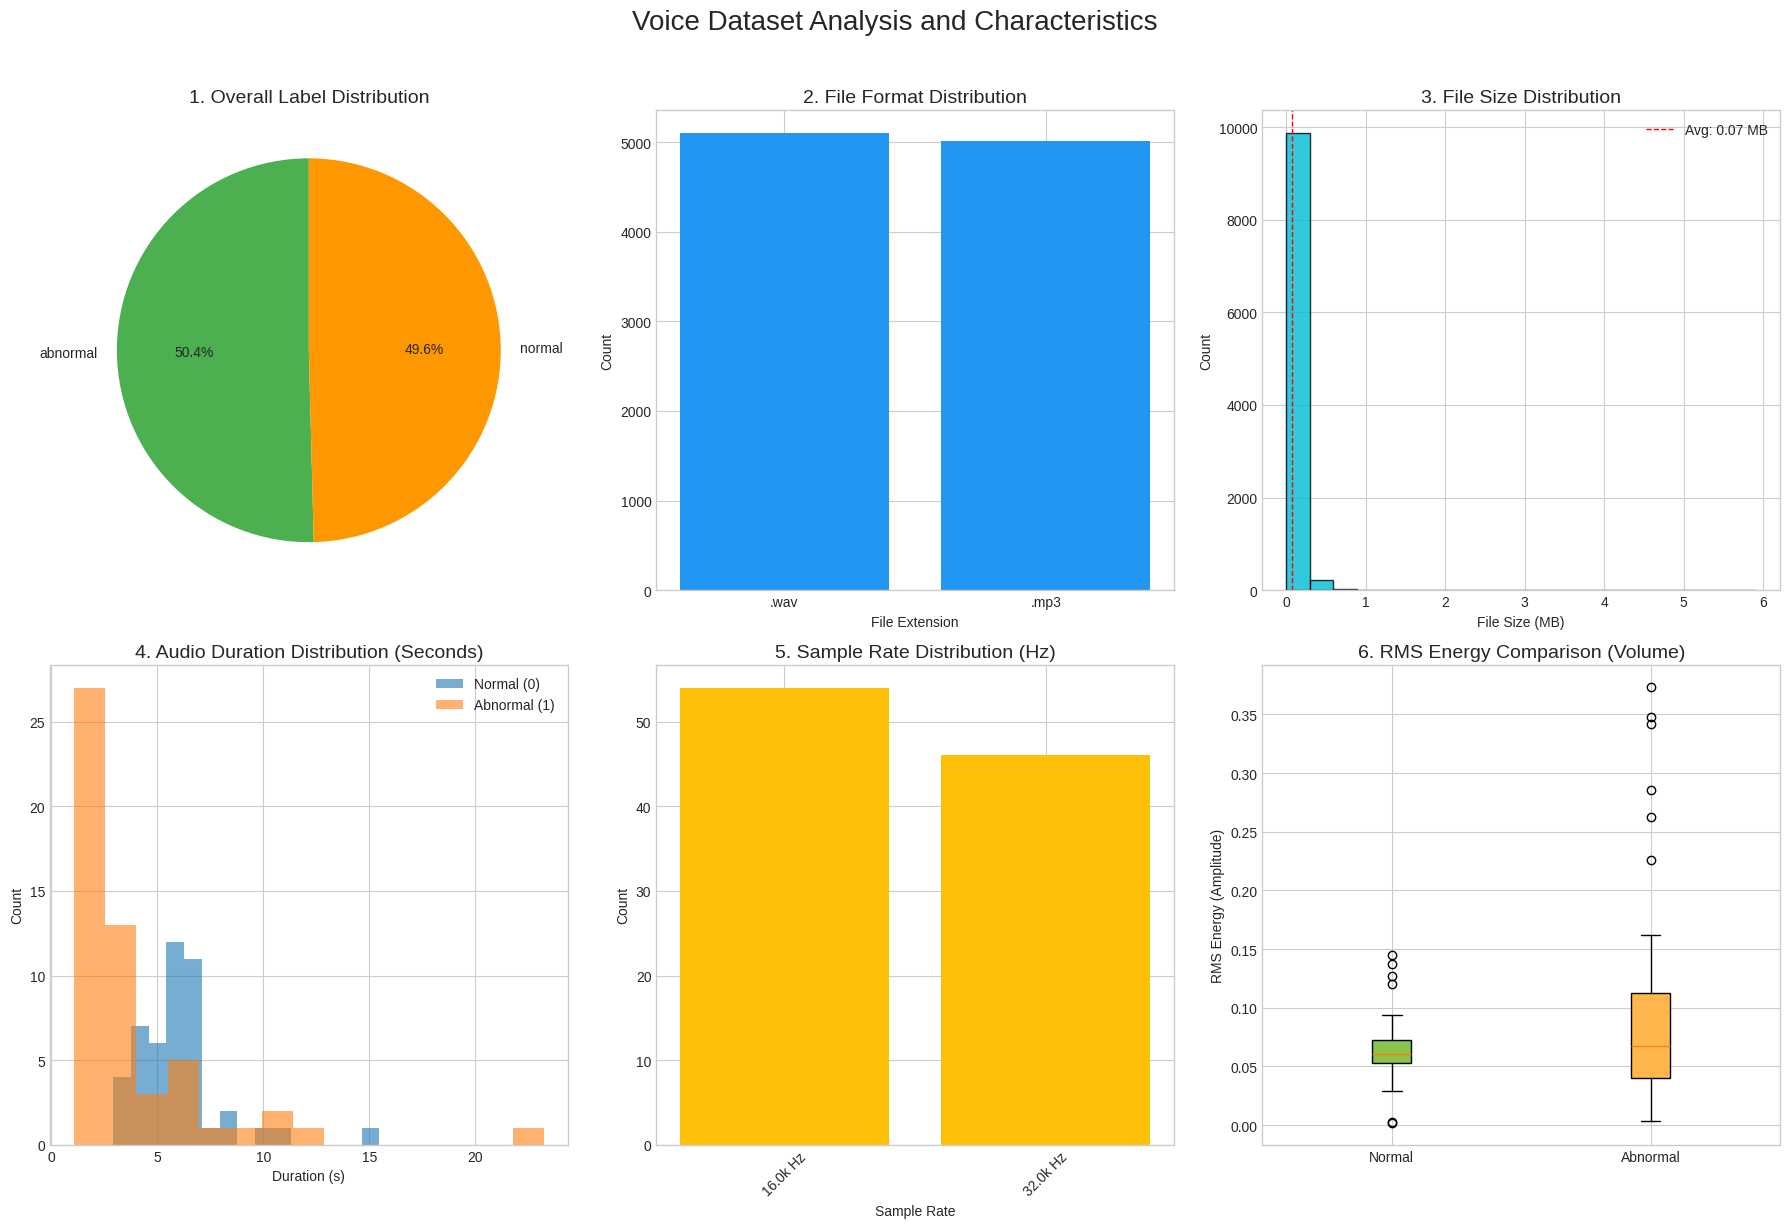


STEP 5: DATASET SUMMARY
Total files in catalog: 10117
Normal voices (Label 0): 5017
Abnormal voices (Label 1): 5100
Class balance ratio: 0.98:1 (Normal:Abnormal)

File formats:
  .wav: 5100 files
  .mp3: 5017 files

File sizes:
  Average: 0.07 MB
  Range: 0.00 - 5.92 MB

Audio properties (from sample of 100 files):
  Average duration: 4.85 seconds
  Duration range: 1.05 - 23.25 seconds
  Unique sample rates (Hz): [np.int64(16000), np.int64(32000)]

Potential Issues:
  ✅ Class balance looks reasonable (ratio between 1:3 and 3:1).
  ⚠️  Multiple sample rates detected. Standardization (resampling) is highly recommended for model training.
  ✅ Audio durations show low variance.

Next steps:
1. Review the generated files (dataset_catalog.csv and data_analysis.png) in the ProcessedData folder.
2. Based on the summary (e.g., multiple sample rates), proceed to Step 2: Audio Preprocessing (resampling, trimming, etc.).


In [9]:
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
from pathlib import Path
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import random

# Suppress warnings from librosa and matplotlib for cleaner output
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

class VoiceDataPreparator:
    def __init__(self, main_folder_path):
        """
        Initialize the data preparator

        Args:
            main_folder_path: Path to your main folder containing normal and abnormal voice subfolders
        """
        self.main_folder_path = Path(main_folder_path)

        # Try different possible folder names
        # Note: Added 'mozilla' to normal and 'torgo' to abnormal based on common datasets
        possible_normal_names = ["Normal Voices", "Normal", "normal", "normal voices", "mozilla", "Mozilla"]
        possible_abnormal_names = ["Abnormal Voices", "Abnormal", "abnormal", "abnormal voices", "torgo", "TORGO"]


        self.normal_folder = None
        self.abnormal_folder = None

        # Find normal folder
        for name in possible_normal_names:
            potential_path = self.main_folder_path / name
            if potential_path.exists() and potential_path.is_dir():
                self.normal_folder = potential_path
                break

        # Find abnormal folder
        for name in possible_abnormal_names:
            potential_path = self.main_folder_path / name
            if potential_path.exists() and potential_path.is_dir():
                self.abnormal_folder = potential_path
                break

        self.supported_formats = ['.mp3', '.wav', '.flac']

        # Create output directories
        # Using a default path for processed data in MyDrive
        self.processed_data_dir = Path("/content/drive/MyDrive/ProcessedData")
        self.processed_data_dir.mkdir(exist_ok=True)
        print(f"Output directory initialized at: {self.processed_data_dir}")

    def scan_audio_files(self):
        """Scan and catalog all audio files"""
        print("\n" + "="*50)
        print("STEP 1: Scanning Audio Files")
        print("="*50)
        print(f"Main folder path: {self.main_folder_path}")

        # Check if main folder exists
        if not self.main_folder_path.exists():
            print(f"❌ Main folder does not exist: {self.main_folder_path}")
            print("Please check your path!")
            return [], [] # Explicitly return empty lists

        print(f"✅ Main folder exists")

        # List contents of main folder for verification
        print(f"Contents of main folder:")
        try:
            for item in self.main_folder_path.iterdir():
                print(f"  - {item.name} ({'folder' if item.is_dir() else 'file'})")
        except Exception as e:
             print(f"  Could not list contents: {e}")

        normal_files = []
        abnormal_files = []

        # Scan normal folder
        print(f"\n--- Scanning normal folder ---")
        if self.normal_folder and self.normal_folder.exists():
            print(f"✅ Normal folder found: {self.normal_folder}")
            for ext in self.supported_formats:
                # Search directly and recursively
                # Using set to avoid adding duplicates if glob returns them (though unlikely with **/*)
                found_files = set(self.normal_folder.glob(f"*{ext}"))
                found_files.update(self.normal_folder.glob(f"**/*{ext}"))

                initial_count = len(normal_files)
                for f in found_files:
                    if f not in normal_files and f.is_file():
                        normal_files.append(f)

                print(f"  Found {len(normal_files) - initial_count} new {ext} files (including subfolders)")
        else:
            print(f"❌ Normal folder not found! (Tried: {self.normal_folder})")

        # Scan abnormal folder
        print(f"\n--- Scanning abnormal folder ---")
        # 🐛 FIX APPLIED: Corrected 'self.abfolder_path.exists()' to 'self.abnormal_folder.exists()'
        if self.abnormal_folder and self.abnormal_folder.exists():
            print(f"✅ Abnormal folder found: {self.abnormal_folder}")
            for ext in self.supported_formats:
                # Search directly and recursively
                found_files = set(self.abnormal_folder.glob(f"*{ext}"))
                found_files.update(self.abnormal_folder.glob(f"**/*{ext}"))

                initial_count = len(abnormal_files)
                for f in found_files:
                    if f not in abnormal_files and f.is_file():
                        abnormal_files.append(f)

                print(f"  Found {len(abnormal_files) - initial_count} new {ext} files (including subfolders)")
        else:
            print(f"❌ Abnormal folder not found! (Tried: {self.abnormal_folder})")

        # Remove duplicates (redundant if using sets above, but good safeguard)
        normal_files = list(set(normal_files))
        abnormal_files = list(set(abnormal_files))

        print(f"\n📊 FINAL SCAN RESULTS:")
        print(f"Found {len(normal_files)} total normal voice files")
        print(f"Found {len(abnormal_files)} total abnormal voice files")

        if len(normal_files) == 0 and len(abnormal_files) == 0:
            print("\n🔍 TROUBLESHOOTING:")
            print("No audio files found. Please re-check the path, folder names, and file extensions.")

        # 💡 CRITICAL: Ensure function always returns a tuple of lists.
        return normal_files, abnormal_files

    def create_dataset_catalog(self, normal_files, abnormal_files, max_abnormal=5100):
        """Create a catalog CSV file with file paths and labels"""
        print("\n" + "="*50)
        print("STEP 2: Creating Dataset Catalog (CSV)")
        print("="*50)

        # Check if we have any files
        if len(normal_files) == 0 and len(abnormal_files) == 0:
            print("❌ No audio files found! Cannot create catalog.")
            return pd.DataFrame()  # Return empty dataframe

        print(f"Found {len(abnormal_files)} abnormal files.")

        # Randomly sample abnormal files if we have more than max_abnormal
        if len(abnormal_files) > max_abnormal:
            random.seed(42) # Use built-in random for sampling paths
            abnormal_files = random.sample(abnormal_files, max_abnormal)
            print(f"Selected {len(abnormal_files)} abnormal files out of original set ({max_abnormal} limit)")
        else:
            print(f"Using all {len(abnormal_files)} abnormal files.")

        data = []

        # Add normal files (Label: 0)
        for file_path in tqdm(normal_files, desc="Processing Normal Files"):
            try:
                data.append({
                    'file_path': str(file_path),
                    'filename': file_path.name,
                    'label': 0,
                    'label_text': 'normal',
                    'file_size_mb': file_path.stat().st_size / (1024*1024),
                    'extension': file_path.suffix.lower()
                })
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

        # Add selected abnormal files (Label: 1)
        for file_path in tqdm(abnormal_files, desc="Processing Abnormal Files"):
            try:
                data.append({
                    'file_path': str(file_path),
                    'filename': file_path.name,
                    'label': 1,
                    'label_text': 'abnormal',
                    'file_size_mb': file_path.stat().st_size / (1024*1024),
                    'extension': file_path.suffix.lower()
                })
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

        if len(data) == 0:
            print("❌ No valid files processed!")
            return pd.DataFrame()

        df = pd.DataFrame(data)

        # Save full catalog
        catalog_path = self.processed_data_dir / "dataset_catalog.csv"
        df.to_csv(catalog_path, index=False)
        print(f"✅ Dataset catalog saved to: {catalog_path} (Total rows: {len(df)})")

        return df

    def analyze_audio_properties(self, df, sample_size=100):
        """Analyze audio properties from a sample of files"""
        print("\n" + "="*50)
        print(f"STEP 3: Analyzing Audio Properties from {sample_size} Samples")
        print("="*50)

        # Sample files for analysis
        # Ensure sample_size doesn't exceed the total number of files
        sample_df = df.sample(n=min(sample_size, len(df)), random_state=42)

        audio_properties = []

        # Use tqdm for progress bar during analysis
        for _, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Analyzing Audio Features"):
            try:
                # Load audio file without setting a target sample rate (sr=None)
                y, sr = librosa.load(row['file_path'], sr=None, mono=True)

                # Skip files that load to an empty array
                if len(y) == 0:
                    raise ValueError("Audio file is empty.")

                # Calculate basic properties
                audio_properties.append({
                    'filename': row['filename'],
                    'label': row['label'],
                    'duration': len(y) / sr,
                    'sample_rate': sr,
                    'n_samples': len(y),
                    # Ensure features are calculated correctly
                    'rms_energy': np.sqrt(np.mean(y**2)) if len(y) > 0 else 0,
                    'zero_crossing_rate': np.mean(librosa.feature.zero_crossing_rate(y=y)) if len(y) > 0 else 0,
                })

            except Exception as e:
                print(f"\nError processing {row['filename']} (Label {row['label']}): {e}")
                continue

        properties_df = pd.DataFrame(audio_properties)

        if properties_df.empty:
            print("❌ Failed to analyze any files.")
            return properties_df

        # Save properties
        properties_path = self.processed_data_dir / "audio_properties.csv"
        properties_df.to_csv(properties_path, index=False)
        print(f"✅ Audio properties saved to: {properties_path}")

        return properties_df

    def visualize_data_distribution(self, df, properties_df):
        """Create visualizations of the data distribution"""
        print("\n" + "="*50)
        print("STEP 4: Generating Visualizations")
        print("="*50)

        # Use a style for better plot aesthetics
        plt.style.use('seaborn-v0_8-whitegrid')

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Voice Dataset Analysis and Characteristics', fontsize=20, y=1.02)

        # --- Row 1: Catalog Analysis ---

        # 1. Label distribution
        label_counts = df['label_text'].value_counts()
        axes[0, 0].pie(label_counts.values, labels=label_counts.index,
                       autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#FF9800'])
        axes[0, 0].set_title('1. Overall Label Distribution', fontsize=14)

        # 2. File format distribution
        format_counts = df['extension'].value_counts()
        axes[0, 1].bar(format_counts.index, format_counts.values, color='#2196F3')
        axes[0, 1].set_title('2. File Format Distribution', fontsize=14)
        axes[0, 1].set_xlabel('File Extension')
        axes[0, 1].set_ylabel('Count')

        # 3. File size distribution
        axes[0, 2].hist(df['file_size_mb'], bins=20, alpha=0.8, color='#00BCD4', edgecolor='black')
        axes[0, 2].set_title('3. File Size Distribution', fontsize=14)
        axes[0, 2].set_xlabel('File Size (MB)')
        axes[0, 2].set_ylabel('Count')
        axes[0, 2].axvline(df['file_size_mb'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Avg: {df["file_size_mb"].mean():.2f} MB')
        axes[0, 2].legend()

        # --- Row 2: Audio Properties Analysis (from sample) ---
        if not properties_df.empty:

            # 4. Duration distribution by label
            for label in [0, 1]:
                subset = properties_df[properties_df['label'] == label]
                label_name = 'Normal (0)' if label == 0 else 'Abnormal (1)'
                axes[1, 0].hist(subset['duration'], alpha=0.6, label=label_name, bins=15, histtype='stepfilled')
            axes[1, 0].set_title('4. Audio Duration Distribution (Seconds)', fontsize=14)
            axes[1, 0].set_xlabel('Duration (s)')
            axes[1, 0].set_ylabel('Count')
            axes[1, 0].legend()

            # 5. Sample rate distribution
            sr_counts = properties_df['sample_rate'].value_counts().sort_index()
            # Convert keys to strings for better plotting if few unique rates
            x_labels = [f'{sr/1000:.1f}k Hz' for sr in sr_counts.index]
            axes[1, 1].bar(x_labels, sr_counts.values, color='#FFC107')
            axes[1, 1].set_title('5. Sample Rate Distribution (Hz)', fontsize=14)
            axes[1, 1].set_xlabel('Sample Rate')
            axes[1, 1].set_ylabel('Count')
            axes[1, 1].tick_params(axis='x', rotation=45)

            # 6. RMS Energy comparison (Box Plot)
            data_to_plot = [
                properties_df[properties_df['label'] == 0]['rms_energy'],
                properties_df[properties_df['label'] == 1]['rms_energy']
            ]
            box_plot = axes[1, 2].boxplot(data_to_plot, patch_artist=True,
                                          labels=['Normal', 'Abnormal'])

            # Customize box colors
            colors = ['#8BC34A', '#FFB74D']
            for patch, color in zip(box_plot['boxes'], colors):
                patch.set_facecolor(color)

            axes[1, 2].set_title('6. RMS Energy Comparison (Volume)', fontsize=14)
            axes[1, 2].set_ylabel('RMS Energy (Amplitude)')

        else:
            # Hide the second row if no properties were analyzed
            for i in range(3):
                fig.delaxes(axes[1, i])
            print("Skipped audio properties plots due to empty properties data.")


        plt.tight_layout()

        # Save plot
        plot_path = self.processed_data_dir / "data_analysis.png"
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"✅ Analysis plots saved to: {plot_path}")
        plt.show()

    def print_summary(self, df, properties_df):
        """Print dataset summary"""
        print("\n" + "="*50)
        print("STEP 5: DATASET SUMMARY")
        print("="*50)

        total_normal = len(df[df['label'] == 0])
        total_abnormal = len(df[df['label'] == 1])

        print(f"Total files in catalog: {len(df)}")
        print(f"Normal voices (Label 0): {total_normal}")
        print(f"Abnormal voices (Label 1): {total_abnormal}")

        # Calculate balance ratio safely
        if total_abnormal > 0 and total_normal > 0:
            balance_ratio = total_normal / total_abnormal
            print(f"Class balance ratio: {balance_ratio:.2f}:1 (Normal:Abnormal)")
        else:
            print("Class balance ratio: Cannot calculate (one class is empty)")

        print(f"\nFile formats:")
        if not df.empty:
            for ext, count in df['extension'].value_counts().items():
                print(f"  {ext}: {count} files")

            print(f"\nFile sizes:")
            print(f"  Average: {df['file_size_mb'].mean():.2f} MB")
            print(f"  Range: {df['file_size_mb'].min():.2f} - {df['file_size_mb'].max():.2f} MB")

        # --- Audio Properties Summary (from sample) ---
        if not properties_df.empty:
            print(f"\nAudio properties (from sample of {len(properties_df)} files):")
            print(f"  Average duration: {properties_df['duration'].mean():.2f} seconds")
            print(f"  Duration range: {properties_df['duration'].min():.2f} - {properties_df['duration'].max():.2f} seconds")

            unique_srs = sorted(properties_df['sample_rate'].unique())
            print(f"  Unique sample rates (Hz): {unique_srs}")

            # --- Potential Issues Check ---
            print(f"\nPotential Issues:")

            # Check for significant class imbalance (e.g., ratio > 3 or < 1/3)
            if total_abnormal > 0 and total_normal > 0:
                if balance_ratio > 3 or balance_ratio < (1/3):
                    print("  ⚠️  Significant class imbalance detected! Consider augmentation or sampling strategies.")
                else:
                    print("  ✅ Class balance looks reasonable (ratio between 1:3 and 3:1).")

            # Check for sample rate variation
            if len(unique_srs) > 1:
                print("  ⚠️  Multiple sample rates detected. Standardization (resampling) is highly recommended for model training.")
            else:
                print("  ✅ Consistent sample rate detected.")

            # Check for duration variation
            if properties_df['duration'].std() > 5: # Arbitrary threshold for large variance
                print("  ⚠️  High variation in audio durations. Padding/truncation will be necessary during preprocessing.")
            else:
                print("  ✅ Audio durations show low variance.")
        else:
            print("\nAudio properties analysis skipped.")

# Usage example:
if __name__ == "__main__":
    # Your correct path must point to the folder containing "Abnormal Voices" and "Normal Voices"
    # Based on your input: /SpeechRecognition/MozillaVoices/
    main_folder_path = "/content/drive/MyDrive/SpeechRecognition/MozillaVoices"

    # Check if we are in a Google Colab environment for path guidance
    if not os.path.isdir(main_folder_path):
        print(f"🚨 ALERT: The path '{main_folder_path}' does not seem to exist.")
        print("Please modify the 'main_folder_path' variable below to match your Google Drive setup.")
        # Attempt to prompt for mount if path doesn't exist
        if not os.path.isdir('/content/drive'):
             print("\nNote: You may need to run 'from google.colab import drive; drive.mount('/content/drive')' first.")

    # Initialize preparator
    preparator = VoiceDataPreparator(main_folder_path)

    # Step 1: Scan files
    # This now correctly returns two lists, avoiding the TypeError.
    normal_files, abnormal_files = preparator.scan_audio_files()

    # Step 2: Create catalog (using the user-specified 5100 limit for abnormal files)
    df = preparator.create_dataset_catalog(normal_files, abnormal_files, max_abnormal=5100)

    # Step 3, 4, 5: Analyze, Visualize, and Summarize
    if not df.empty:
        # Analyze a larger sample of 100 files
        properties_df = preparator.analyze_audio_properties(df, sample_size=100)

        if not properties_df.empty:
            # Visualize and save the plots
            preparator.visualize_data_distribution(df, properties_df)

        # Print final summary
        preparator.print_summary(df, properties_df)
    else:
        print("\n" + "="*50)
        print("❌ PREPARATION FAILED: No files were found or processed.")
        print("Ensure 'main_folder_path' is correct and files exist in subdirectories.")
        print("="*50)

    print("\nNext steps:")
    print("1. Review the generated files (dataset_catalog.csv and data_analysis.png) in the ProcessedData folder.")
    print("2. Based on the summary (e.g., multiple sample rates), proceed to Step 2: Audio Preprocessing (resampling, trimming, etc.).")


# Audio Preprocessing & Feature Extraction.

In [10]:
import torch.nn as nn
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import pickle
from pathlib import Path
import gc
warnings.filterwarnings('ignore')

In [11]:
import pandas as pd
import numpy as np
import librosa
import torch
import pickle
import gc
from tqdm import tqdm
from pathlib import Path
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.model_selection import train_test_split

class VoiceFeatureExtractor:
    def __init__(self, catalog_path="/content/drive/MyDrive/ProcessedData/dataset_catalog.csv"):
        """
        Initialize the feature extractor
        """
        self.catalog_path = catalog_path
        self.df = pd.read_csv(catalog_path)

        # Audio processing parameters
        self.target_sr = 16000
        self.max_duration = 10  # Maximum audio duration in seconds
        self.min_duration = 2   # Minimum audio duration in seconds

        # Determine device and set batch size
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.batch_size = 16 if self.device == "cuda" else 8 # Adjust based on your GPU memory

        # Initialize Wav2Vec2 model
        print(f"Loading Wav2Vec2 model on device: {self.device}...")
        self.processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
        self.model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(self.device)
        self.model.eval()

        # Create directories
        self.features_dir = Path("/content/drive/MyDrive/ProcessedData/features")
        self.features_dir.mkdir(exist_ok=True)

        print(f"✅ Feature extractor initialized (Batch size: {self.batch_size})")
        print(f"📊 Dataset: {len(self.df)} files ({sum(self.df['label']==0)} normal, {sum(self.df['label']==1)} abnormal)")

    def preprocess_audio(self, audio_path, target_sr=16000, max_duration=10):
        """
        Preprocess a single audio file
        """
        try:
            # Load audio
            y, sr = librosa.load(audio_path, sr=target_sr)

            # Remove silence from beginning and end
            y, _ = librosa.effects.trim(y, top_db=20)

            # Check duration
            duration = len(y) / sr
            if duration < self.min_duration:
                # Pad short audio
                required_length = int(self.min_duration * sr)
                if len(y) < required_length:
                    y = np.pad(y, (0, required_length - len(y)), mode='constant')
            elif duration > max_duration:
                # Truncate long audio
                y = y[:int(max_duration * sr)]

            # Normalize audio
            if np.max(np.abs(y)) > 0:
                y = y / np.max(np.abs(y))

            return y

        except Exception as e:
            # print(f"Error processing {audio_path}: {e}")
            return None

    def extract_wav2vec2_features_batch(self, audio_arrays):
        """
        Extract features using Wav2Vec2 model for a batch of audio arrays.
        """
        try:
            # Process batch of audio arrays
            inputs = self.processor(audio_arrays,
                                  sampling_rate=self.target_sr,
                                  return_tensors="pt",
                                  padding=True)

            # Move input to GPU
            input_values = inputs.input_values.to(self.device)

            # Extract features
            with torch.no_grad():
                outputs = self.model(input_values)

            # Get hidden states (features)
            hidden_states = outputs.last_hidden_state

            # Global average pooling (over the sequence dimension, dim=1)
            # and move to CPU before converting to numpy
            features = torch.mean(hidden_states, dim=1).cpu().numpy()

            return features

        except Exception as e:
            print(f"Error extracting features in batch: {e}")
            return None

    def extract_traditional_features(self, audio_array, sr=16000):
        """
        Extract traditional audio features
        """
        try:
            features = {}

            # MFCCs
            mfccs = librosa.feature.mfcc(y=audio_array, sr=sr, n_mfcc=13)
            features['mfcc_mean'] = np.mean(mfccs, axis=1)
            features['mfcc_std'] = np.std(mfccs, axis=1)

            # Spectral features
            spectral_centroids = librosa.feature.spectral_centroid(y=audio_array, sr=sr)[0]
            features['spectral_centroid_mean'] = np.mean(spectral_centroids)
            features['spectral_centroid_std'] = np.std(spectral_centroids)

            # Zero crossing rate
            zcr = librosa.feature.zero_crossing_rate(audio_array)[0]
            features['zcr_mean'] = np.mean(zcr)
            features['zcr_std'] = np.std(zcr)

            # RMS Energy
            rms = librosa.feature.rms(y=audio_array)[0]
            features['rms_mean'] = np.mean(rms)
            features['rms_std'] = np.std(rms)

            # Pitch features
            pitches, magnitudes = librosa.piptrack(y=audio_array, sr=sr)
            pitches = pitches[pitches > 0]
            if len(pitches) > 0:
                features['pitch_mean'] = np.mean(pitches)
                features['pitch_std'] = np.std(pitches)
            else:
                features['pitch_mean'] = 0
                features['pitch_std'] = 0

            return features

        except Exception as e:
            print(f"Error extracting traditional features: {e}")
            return {}

    def process_dataset_in_chunks(self, start_index=0, end_index=None, chunk_save_path=None, use_traditional=True):
        """
        Process a specific chunk of the dataset and save the resulting features.
        """

        df_chunk = self.df.iloc[start_index:end_index]
        if df_chunk.empty:
            print("🛑 Chunk is empty. Nothing to process.")
            return None

        print(f"🚀 Starting feature extraction for indices {start_index} to {start_index + len(df_chunk)}...")

        chunk_features = []
        chunk_traditional_features = []
        chunk_labels = []
        chunk_filenames = []
        chunk_successful_files = []

        # Lists to hold the batch data
        batch_audio_arrays = []
        batch_metadata = []

        total_iterations = len(df_chunk)

        # Use idx relative to the chunk start for accurate iteration count
        for i, row in tqdm(enumerate(df_chunk.itertuples(index=False), start=1),
                           total=total_iterations,
                           desc=f"Processing chunk {start_index}-{start_index + len(df_chunk)}"):
            try:
                audio = self.preprocess_audio(row.file_path)

                if audio is None:
                    continue

                # Collect audio and metadata for batch
                batch_audio_arrays.append(audio)
                batch_metadata.append({
                    'label': row.label,
                    'filename': row.filename,
                    'file_path': row.file_path,
                    'audio': audio if use_traditional else None
                })

                # Determine if the batch is full or if it's the last iteration
                is_batch_full = len(batch_audio_arrays) == self.batch_size
                is_last_iteration = i == total_iterations

                if is_batch_full or (is_last_iteration and batch_audio_arrays):

                    # 1. Extract Wav2Vec2 features (Batch)
                    wav2vec_features_batch = self.extract_wav2vec2_features_batch(batch_audio_arrays)

                    if wav2vec_features_batch is None:
                        # Clear batch lists and continue if batch failed
                        batch_audio_arrays.clear()
                        batch_metadata.clear()
                        continue

                    # 2. Unpack features and metadata
                    for j, features in enumerate(wav2vec_features_batch):
                        metadata = batch_metadata[j]

                        chunk_features.append(features)
                        chunk_labels.append(metadata['label'])
                        chunk_filenames.append(metadata['filename'])
                        chunk_successful_files.append(metadata['file_path'])

                        # 3. Extract traditional features (Single, fast operation)
                        if use_traditional:
                            trad_features = self.extract_traditional_features(metadata['audio'])
                            chunk_traditional_features.append(trad_features)

                    # Clear batch lists for the next batch
                    batch_audio_arrays.clear()
                    batch_metadata.clear()

            except Exception as e:
                print(f"\nError processing file {row.filename}: {e}")
                # Clear batch lists if an error occurred in the middle of a batch
                batch_audio_arrays.clear()
                batch_metadata.clear()
                continue

        print(f"\n✅ Successfully processed {len(chunk_features)} files in chunk.")

        # Convert traditional features to array
        X_traditional_chunk = None
        if use_traditional and chunk_traditional_features:
            # Flatten features
            traditional_arrays = []
            for feat_dict in chunk_traditional_features:
                feat_array = []
                feat_array.extend(feat_dict['mfcc_mean'])
                feat_array.extend(feat_dict['mfcc_std'])
                feat_array.extend([
                    feat_dict['spectral_centroid_mean'], feat_dict['spectral_centroid_std'],
                    feat_dict['zcr_mean'], feat_dict['zcr_std'],
                    feat_dict['rms_mean'], feat_dict['rms_std'],
                    feat_dict['pitch_mean'], feat_dict['pitch_std']
                ])
                traditional_arrays.append(feat_array)

            X_traditional_chunk = np.array(traditional_arrays)

        # Final chunk data
        chunk_data = {
            'X_wav2vec': np.array(chunk_features),
            'X_traditional': X_traditional_chunk,
            'y': np.array(chunk_labels),
            'filenames': chunk_filenames,
            'file_paths': chunk_successful_files
        }

        # Save chunk
        if chunk_save_path is None:
            chunk_save_path = self.features_dir / f"extracted_features_chunk_{start_index}_to_{start_index + len(chunk_data['y']) - 1}.pkl"

        with open(chunk_save_path, 'wb') as f:
            pickle.dump(chunk_data, f)

        print(f"💾 Chunk features saved to: {chunk_save_path}")
        return chunk_data

    def create_train_test_split(self, features_data, test_size=0.2, val_size=0.1):
        """
        Create train/validation/test splits (This was the missing method)
        """
        X = features_data['X_wav2vec']
        y = features_data['y']

        # First split: train+val vs test
        X_trainval, X_test, y_trainval, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        # Second split: train vs val
        val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_trainval, y_trainval, test_size=val_size_adjusted, random_state=42, stratify=y_trainval
        )

        splits = {
            'X_train': X_train, 'y_train': y_train,
            'X_val': X_val, 'y_val': y_val,
            'X_test': X_test, 'y_test': y_test
        }

        # Save splits
        splits_path = self.features_dir / "data_splits.pkl"
        with open(splits_path, 'wb') as f:
            pickle.dump(splits, f)

        print(f"📊 Data splits created:")
        print(f"   Train: {X_train.shape[0]} samples")
        print(f"   Validation: {X_val.shape[0]} samples")
        print(f"   Test: {X_test.shape[0]} samples")
        print(f"💾 Splits saved to: {splits_path}")

        return splits

# ----------------------------------------------------------------------
# Usage Example - Main Execution Block
# ----------------------------------------------------------------------
if __name__ == "__main__":
    extractor = VoiceFeatureExtractor("/content/drive/MyDrive/ProcessedData/dataset_catalog.csv")

    # --- Configuration ---
    TOTAL_FILES = len(extractor.df)
    CHUNK_SIZE = 500  # Based on your logs, this size worked well

    # --- Chunking Loop ---
    start_idx = 0
    all_features = []

    print("\nStarting checkpoint process. Existing chunks will be loaded.")
    while start_idx < TOTAL_FILES:
        end_idx = min(start_idx + CHUNK_SIZE, TOTAL_FILES)

        # Adjust end_idx for the last chunk to match the final log index
        if end_idx == TOTAL_FILES:
            end_idx_for_path = TOTAL_FILES - 1
        else:
            end_idx_for_path = end_idx - 1

        chunk_path = extractor.features_dir / f"extracted_features_chunk_{start_idx}_to_{end_idx_for_path}.pkl"

        chunk_data = None # Initialize chunk_data before loop

        if chunk_path.exists():
            # ⏩ SUCCESSFUL CHECKPOINT LOAD
            print(f"⏩ Skipping chunk {start_idx}-{end_idx_for_path}: File already exists. Loading data...")
            try:
                with open(chunk_path, 'rb') as f:
                    chunk_data = pickle.load(f)
            except Exception as e:
                print(f"⚠️ Error loading checkpoint {chunk_path}: {e}. Will attempt to re-process.")
                # Fall through to the else block to re-process if loading fails

        if chunk_data is None:
            # 🚀 PROCESS NEW CHUNK OR RE-PROCESS FAILED LOAD
            print(f"\n=======================================================")
            print(f"🚀 PROCESSING NEW/RE-PROCESS CHUNK: Indices {start_idx} to {end_idx-1}")
            print(f"=======================================================")
            chunk_data = extractor.process_dataset_in_chunks(
                start_index=start_idx,
                end_index=end_idx,
                chunk_save_path=chunk_path,
                use_traditional=True
            )

        if chunk_data:
            all_features.append(chunk_data)

        # Move to the next chunk
        start_idx = end_idx

        # Clean up memory after each chunk
        gc.collect()
        torch.cuda.empty_cache()

    print("\n✅ All chunks processed or loaded.")

    # --- Combine and Finalize ---
    if all_features:
        print("\n🔄 Combining all feature chunks...")

        # Concatenate arrays from all chunks
        X_wav2vec_all = np.concatenate([d['X_wav2vec'] for d in all_features])
        y_all = np.concatenate([d['y'] for d in all_features])
        filenames_all = [f for d in all_features for f in d['filenames']]
        file_paths_all = [f for d in all_features for f in d['file_paths']]

        if all_features[0]['X_traditional'] is not None:
            X_traditional_all = np.concatenate([d['X_traditional'] for d in all_features])
        else:
            X_traditional_all = None

        features_data_full = {
            'X_wav2vec': X_wav2vec_all,
            'X_traditional': X_traditional_all,
            'y': y_all,
            'filenames': filenames_all,
            'file_paths': file_paths_all
        }

        # Save the final combined dataset
        final_path = extractor.features_dir / "extracted_features_FULL.pkl"
        with open(final_path, 'wb') as f:
            pickle.dump(features_data_full, f)

        print(f"💾 Final combined features saved to: {final_path}")
        print(f"📊 Final combined shape: {X_wav2vec_all.shape}")

        # Create train/test splits - This is the line that will now succeed
        splits = extractor.create_train_test_split(features_data_full)

    print("\n🎉 Feature extraction and splitting process completed!")

Loading Wav2Vec2 model on device: cpu...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Feature extractor initialized (Batch size: 8)
📊 Dataset: 10117 files (5017 normal, 5100 abnormal)

Starting checkpoint process. Existing chunks will be loaded.
⏩ Skipping chunk 0-499: File already exists. Loading data...
⏩ Skipping chunk 500-999: File already exists. Loading data...
⏩ Skipping chunk 1000-1499: File already exists. Loading data...
⏩ Skipping chunk 1500-1999: File already exists. Loading data...
⏩ Skipping chunk 2000-2499: File already exists. Loading data...
⏩ Skipping chunk 2500-2999: File already exists. Loading data...
⏩ Skipping chunk 3000-3499: File already exists. Loading data...
⏩ Skipping chunk 3500-3999: File already exists. Loading data...
⏩ Skipping chunk 4000-4499: File already exists. Loading data...
⏩ Skipping chunk 4500-4999: File already exists. Loading data...
⏩ Skipping chunk 5000-5499: File already exists. Loading data...
⏩ Skipping chunk 5500-5999: File already exists. Loading data...
⏩ Skipping chunk 6000-6499: File already exists. Loading data...

# Training phase

In [12]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# ====================================================================
# 1. Load Data
# ====================================================================

print("Loading data splits...")
try:
    # Load the data splits saved in the previous step
    with open('/content/drive/MyDrive/ProcessedData/features/data_splits.pkl', 'rb') as f:
        splits = pickle.load(f)

    # Assign features and labels
    X_train, y_train = splits['X_train'], splits['y_train']
    X_val, y_val = splits['X_val'], splits['y_val']
    X_test, y_test = splits['X_test'], splits['y_test']

    # Ensure data is in float32 for model and labels are correct type
    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_val = y_val.astype(np.float32)
    y_test = y_test.astype(np.float32)

    print(f"Data Loaded: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")

except FileNotFoundError:
    print("FATAL ERROR: data_splits.pkl not found. Ensure the feature extraction and splitting step was completed successfully.")
    # Stop execution if data isn't found
    raise

# ====================================================================
# 2. Define Model Architecture (Feedforward Neural Network - FNN)
# ====================================================================

input_shape = X_train.shape[1]
print(f"Input feature dimension: {input_shape} (Wav2Vec2 embedding size)")

model = models.Sequential([
    layers.Input(shape=(input_shape,), name='Wav2Vec2_Features'),
    # First Dense Layer
    layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    layers.BatchNormalization(), # Added for better training stability
    layers.Dropout(0.3),

    # Second Dense Layer
    layers.Dense(64, activation='relu', kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Output Layer for Binary Classification
    layers.Dense(1, activation='sigmoid', name='output')
], name='Wav2Vec2_FNN_Classifier')

# ====================================================================
# 3. Compile Model
# ====================================================================

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), # Lowered learning rate for stability
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')] # Added AUC metric
)

model.summary()

# ====================================================================
# 4. Train Model
# ====================================================================

# Define Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/ProcessedData/models/best_wav2vec2_fnn_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

print("\nStarting Model Training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50, # Increased epochs since EarlyStopping is used
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=2 # Verbose 2 shows one line per epoch
)

# ====================================================================
# 5. Evaluation and Saving
# ====================================================================

# Load the best model weights saved by ModelCheckpoint
model.load_weights('/content/drive/MyDrive/ProcessedData/models/best_wav2vec2_fnn_model.h5')

print("\n--- Model Evaluation ---")

# Evaluate on Test Set
loss, accuracy, auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")

# Generate Classification Report
y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_pred, target_names=['Normal (0)', 'Abnormal (1)']))

# Save History (Optional but useful for plotting)
history_path = '/content/drive/MyDrive/ProcessedData/models/training_history.pkl'
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)
print(f"\nTraining history saved to: {history_path}")

print("\n✅ Training and Evaluation Complete!")

Loading data splits...
Data Loaded: Train=(7080, 768), Val=(1012, 768), Test=(2024, 768)
Input feature dimension: 768 (Wav2Vec2 embedding size)


Model: "Wav2Vec2_FNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,521 (420.00 KB)

 Trainable params: 107,137 (418.50 KB)

 Non-trainable params: 384 (1.50 KB)


Starting Model Training...
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.55788, saving model to /content/drive/MyDrive/ProcessedData/models/best_wav2vec2_fnn_model.h5


222/222 - 6s - 25ms/step - accuracy: 0.8401 - auc: 0.9107 - loss: 0.3876 - val_accuracy: 0.5860 - val_auc: 0.9506 - val_loss: 0.5579
Epoch 2/50

Epoch 2: val_loss improved from 0.55788 to 0.42679, saving model to /content/drive/MyDrive/ProcessedData/models/best_wav2vec2_fnn_model.h5


222/222 - 1s - 5ms/step - accuracy: 0.9017 - auc: 0.9571 - loss: 0.2602 - val_accuracy: 0.7816 - val_auc: 0.9644 - val_loss: 0.4268
Epoch 3/50

Epoch 3: val_loss improved from 0.42679 to 0.21806, saving model to /content/drive/MyDrive/ProcessedData/models/best_wav2vec2_fnn_model.h5


222/222 - 1s - 5ms/step - accuracy: 0.9062 - auc: 0.9617 - loss: 0.2468 - val_accuracy: 0.9130 - val_auc: 0.9716 - val_loss: 0.2181
Epoch 4/50

Epoch 4: val_loss improved from 0.21806 to 0.20923, saving model to /content/drive/MyDrive/ProcessedData/models/best_wav2vec2_fnn_model.h5


222/222 - 1s - 5ms/step - accuracy: 0.9151 - auc: 0.9657 - loss: 0.2314 - val_accuracy: 0.9170 - val_auc: 0.9751 - val_loss: 0.2092
Epoch 5/50

Epoch 5: val_loss improved from 0.20923 to 0.20546, saving model to /content/drive/MyDrive/ProcessedData/models/best_wav2vec2_fnn_model.h5


222/222 - 1s - 5ms/step - accuracy: 0.9191 - auc: 0.9689 - loss: 0.2208 - val_accuracy: 0.9259 - val_auc: 0.9745 - val_loss: 0.2055
Epoch 6/50

Epoch 6: val_loss improved from 0.20546 to 0.20311, saving model to /content/drive/MyDrive/ProcessedData/models/best_wav2vec2_fnn_model.h5


222/222 - 1s - 5ms/step - accuracy: 0.9203 - auc: 0.9708 - loss: 0.2136 - val_accuracy: 0.9200 - val_auc: 0.9777 - val_loss: 0.2031
Epoch 7/50

Epoch 7: val_loss improved from 0.20311 to 0.17746, saving model to /content/drive/MyDrive/ProcessedData/models/best_wav2vec2_fnn_model.h5


222/222 - 2s - 9ms/step - accuracy: 0.9234 - auc: 0.9746 - loss: 0.2004 - val_accuracy: 0.9289 - val_auc: 0.9810 - val_loss: 0.1775
Epoch 8/50

Epoch 8: val_loss improved from 0.17746 to 0.17409, saving model to /content/drive/MyDrive/ProcessedData/models/best_wav2vec2_fnn_model.h5


222/222 - 2s - 10ms/step - accuracy: 0.9261 - auc: 0.9750 - loss: 0.1973 - val_accuracy: 0.9358 - val_auc: 0.9816 - val_loss: 0.1741
Epoch 9/50

Epoch 9: val_loss did not improve from 0.17409
222/222 - 2s - 7ms/step - accuracy: 0.9258 - auc: 0.9746 - loss: 0.1993 - val_accuracy: 0.9289 - val_auc: 0.9782 - val_loss: 0.1916
Epoch 10/50

Epoch 10: val_loss improved from 0.17409 to 0.16437, saving model to /content/drive/MyDrive/ProcessedData/models/best_wav2vec2_fnn_model.h5


222/222 - 1s - 5ms/step - accuracy: 0.9314 - auc: 0.9772 - loss: 0.1891 - val_accuracy: 0.9348 - val_auc: 0.9827 - val_loss: 0.1644
Epoch 11/50

Epoch 11: val_loss did not improve from 0.16437
222/222 - 1s - 5ms/step - accuracy: 0.9315 - auc: 0.9772 - loss: 0.1879 - val_accuracy: 0.9368 - val_auc: 0.9826 - val_loss: 0.1671
Epoch 12/50

Epoch 12: val_loss did not improve from 0.16437
222/222 - 1s - 5ms/step - accuracy: 0.9323 - auc: 0.9788 - loss: 0.1805 - val_accuracy: 0.9328 - val_auc: 0.9835 - val_loss: 0.1680
Epoch 13/50

Epoch 13: val_loss did not improve from 0.16437
222/222 - 1s - 5ms/step - accuracy: 0.9355 - auc: 0.9800 - loss: 0.1760 - val_accuracy: 0.9308 - val_auc: 0.9814 - val_loss: 0.1744
Epoch 14/50

Epoch 14: val_loss improved from 0.16437 to 0.15483, saving model to /content/drive/MyDrive/ProcessedData/models/best_wav2vec2_fnn_model.h5


222/222 - 1s - 6ms/step - accuracy: 0.9315 - auc: 0.9800 - loss: 0.1780 - val_accuracy: 0.9368 - val_auc: 0.9854 - val_loss: 0.1548
Epoch 15/50

Epoch 15: val_loss did not improve from 0.15483
222/222 - 1s - 5ms/step - accuracy: 0.9404 - auc: 0.9817 - loss: 0.1669 - val_accuracy: 0.9387 - val_auc: 0.9854 - val_loss: 0.1579
Epoch 16/50

Epoch 16: val_loss did not improve from 0.15483
222/222 - 1s - 6ms/step - accuracy: 0.9377 - auc: 0.9817 - loss: 0.1692 - val_accuracy: 0.9358 - val_auc: 0.9831 - val_loss: 0.1648
Epoch 17/50

Epoch 17: val_loss did not improve from 0.15483
222/222 - 2s - 7ms/step - accuracy: 0.9408 - auc: 0.9827 - loss: 0.1641 - val_accuracy: 0.9377 - val_auc: 0.9847 - val_loss: 0.1591
Epoch 18/50

Epoch 18: val_loss did not improve from 0.15483
222/222 - 2s - 9ms/step - accuracy: 0.9419 - auc: 0.9836 - loss: 0.1586 - val_accuracy: 0.9318 - val_auc: 0.9838 - val_loss: 0.1773
Epoch 19/50

Epoch 19: val_loss improved from 0.15483 to 0.15045, saving model to /content/drive

222/222 - 2s - 9ms/step - accuracy: 0.9387 - auc: 0.9825 - loss: 0.1641 - val_accuracy: 0.9387 - val_auc: 0.9850 - val_loss: 0.1504
Epoch 20/50

Epoch 20: val_loss did not improve from 0.15045
222/222 - 1s - 5ms/step - accuracy: 0.9401 - auc: 0.9834 - loss: 0.1593 - val_accuracy: 0.9348 - val_auc: 0.9839 - val_loss: 0.1564
Epoch 21/50

Epoch 21: val_loss improved from 0.15045 to 0.14989, saving model to /content/drive/MyDrive/ProcessedData/models/best_wav2vec2_fnn_model.h5


222/222 - 1s - 5ms/step - accuracy: 0.9421 - auc: 0.9842 - loss: 0.1560 - val_accuracy: 0.9397 - val_auc: 0.9864 - val_loss: 0.1499
Epoch 22/50

Epoch 22: val_loss did not improve from 0.14989
222/222 - 1s - 5ms/step - accuracy: 0.9442 - auc: 0.9861 - loss: 0.1472 - val_accuracy: 0.9368 - val_auc: 0.9855 - val_loss: 0.1527
Epoch 23/50

Epoch 23: val_loss did not improve from 0.14989
222/222 - 1s - 5ms/step - accuracy: 0.9388 - auc: 0.9839 - loss: 0.1585 - val_accuracy: 0.9377 - val_auc: 0.9862 - val_loss: 0.1500
Epoch 24/50

Epoch 24: val_loss did not improve from 0.14989
222/222 - 1s - 5ms/step - accuracy: 0.9424 - auc: 0.9840 - loss: 0.1562 - val_accuracy: 0.9457 - val_auc: 0.9858 - val_loss: 0.1551
Epoch 25/50

Epoch 25: val_loss did not improve from 0.14989
222/222 - 1s - 5ms/step - accuracy: 0.9442 - auc: 0.9845 - loss: 0.1520 - val_accuracy: 0.9397 - val_auc: 0.9872 - val_loss: 0.1573
Epoch 26/50

Epoch 26: val_loss improved from 0.14989 to 0.13873, saving model to /content/drive

222/222 - 1s - 5ms/step - accuracy: 0.9427 - auc: 0.9842 - loss: 0.1553 - val_accuracy: 0.9457 - val_auc: 0.9878 - val_loss: 0.1387
Epoch 27/50

Epoch 27: val_loss did not improve from 0.13873
222/222 - 1s - 5ms/step - accuracy: 0.9465 - auc: 0.9860 - loss: 0.1480 - val_accuracy: 0.9358 - val_auc: 0.9850 - val_loss: 0.1639
Epoch 28/50

Epoch 28: val_loss did not improve from 0.13873
222/222 - 2s - 7ms/step - accuracy: 0.9444 - auc: 0.9863 - loss: 0.1455 - val_accuracy: 0.9377 - val_auc: 0.9870 - val_loss: 0.1602
Epoch 29/50

Epoch 29: val_loss did not improve from 0.13873
222/222 - 2s - 9ms/step - accuracy: 0.9482 - auc: 0.9856 - loss: 0.1467 - val_accuracy: 0.9486 - val_auc: 0.9879 - val_loss: 0.1392
Epoch 30/50

Epoch 30: val_loss did not improve from 0.13873
222/222 - 2s - 9ms/step - accuracy: 0.9476 - auc: 0.9868 - loss: 0.1419 - val_accuracy: 0.9427 - val_auc: 0.9866 - val_loss: 0.1578
Epoch 31/50

Epoch 31: val_loss improved from 0.13873 to 0.13454, saving model to /content/drive

222/222 - 1s - 5ms/step - accuracy: 0.9516 - auc: 0.9880 - loss: 0.1337 - val_accuracy: 0.9516 - val_auc: 0.9888 - val_loss: 0.1345
Epoch 32/50

Epoch 32: val_loss improved from 0.13454 to 0.13302, saving model to /content/drive/MyDrive/ProcessedData/models/best_wav2vec2_fnn_model.h5


222/222 - 1s - 5ms/step - accuracy: 0.9532 - auc: 0.9883 - loss: 0.1333 - val_accuracy: 0.9496 - val_auc: 0.9883 - val_loss: 0.1330
Epoch 33/50

Epoch 33: val_loss did not improve from 0.13302
222/222 - 1s - 5ms/step - accuracy: 0.9506 - auc: 0.9866 - loss: 0.1409 - val_accuracy: 0.9457 - val_auc: 0.9880 - val_loss: 0.1466
Epoch 34/50

Epoch 34: val_loss did not improve from 0.13302
222/222 - 1s - 5ms/step - accuracy: 0.9516 - auc: 0.9872 - loss: 0.1357 - val_accuracy: 0.9506 - val_auc: 0.9880 - val_loss: 0.1340
Epoch 35/50

Epoch 35: val_loss did not improve from 0.13302
222/222 - 1s - 5ms/step - accuracy: 0.9527 - auc: 0.9880 - loss: 0.1342 - val_accuracy: 0.9506 - val_auc: 0.9866 - val_loss: 0.1425
Epoch 36/50

Epoch 36: val_loss did not improve from 0.13302
222/222 - 1s - 5ms/step - accuracy: 0.9510 - auc: 0.9878 - loss: 0.1356 - val_accuracy: 0.9526 - val_auc: 0.9872 - val_loss: 0.1436
Epoch 37/50

Epoch 37: val_loss did not improve from 0.13302
222/222 - 1s - 5ms/step - accuracy:

Generating predictions...
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Detailed Test Set Metrics ---
Accuracy Score: 0.9605
Precision Score: 0.9599
Recall Score: 0.9618
F1 Score: 0.9608
AUC Score: 0.9902

Classification Report:
              precision    recall  f1-score   support

  Normal (0)       0.96      0.96      0.96      1004
Abnormal (1)       0.96      0.96      0.96      1020

    accuracy                           0.96      2024
   macro avg       0.96      0.96      0.96      2024
weighted avg       0.96      0.96      0.96      2024



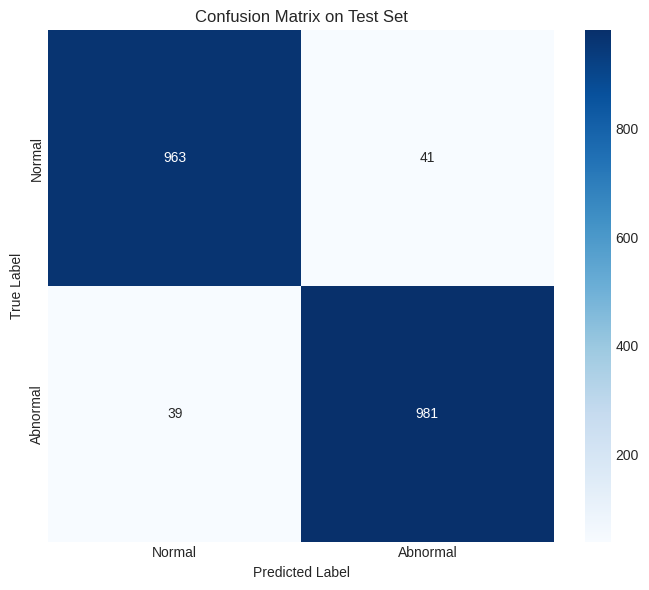

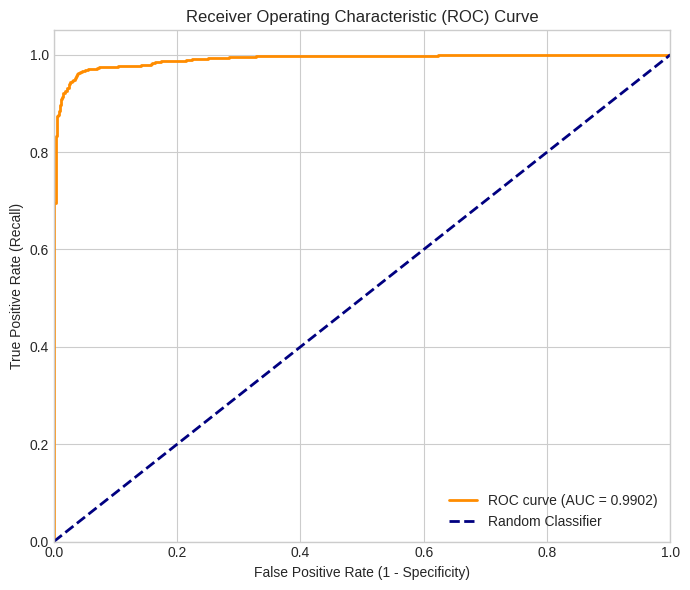

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)

# Assuming 'model' (your trained Keras model) and 'X_test', 'y_test' are in memory.

# ====================================================================
# 1. Prediction on Test Set
# ====================================================================

print("Generating predictions...")
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# ====================================================================
# 2. Calculate and Display Metrics
# ====================================================================

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print("\n--- Detailed Test Set Metrics ---")
print(f"Accuracy Score: {acc:.4f}")
print(f"Precision Score: {prec:.4f}")
print(f"Recall Score: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal (0)', 'Abnormal (1)']))


# ====================================================================
# 3. Confusion Matrix Visualization (Separated Figure)
# ====================================================================

cm = confusion_matrix(y_test, y_pred)

# ⬅️ ADDED plt.figure()
plt.figure(figsize=(7, 6))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Normal', 'Abnormal'],
            yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.tight_layout() # Improves spacing
plt.show()


# ====================================================================
# 4. ROC Curve Visualization (Separated Figure)
# ====================================================================

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# ⬅️ ADDED plt.figure()
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout() # Improves spacing
plt.show()

In [14]:
import os
from pathlib import Path

model_path = '/content/drive/MyDrive/ProcessedData/models/best_wav2vec2_fnn_model.h5'

if Path(model_path).exists():
    print(f"✅ Model found! File size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")
else:
    print("❌ Model file not found at the expected location.")

✅ Model found! File size: 1.27 MB


# Predictions of Heathly and UnHealthy  voices

In [15]:
import librosa
import numpy as np
import tensorflow as tf
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import os
import gc
from pathlib import Path

# --- Configuration ---
# Use the correct path for the Keras model (based on the successful training run)
KERAS_MODEL_PATH = '/content/drive/MyDrive/ProcessedData/models/best_wav2vec2_fnn_model.h5'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ====================================================================
# 1. Initialization: Load Models and Processor
# ====================================================================

print("\n--- Initializing Models ---")

# Load Wav2Vec2 Processor and Model (Used for feature extraction in BOTH tasks)
print("Loading Wav2Vec2...")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(DEVICE)
wav2vec_model.eval()

# Load Your Saved Keras Model (For Health Prediction)
print(f"Loading Keras Model from: {KERAS_MODEL_PATH}...")
try:
    tf_model = tf.keras.models.load_model(KERAS_MODEL_PATH)
except Exception as e:
    print(f"FATAL ERROR: Could not load Keras model. Check the path. Error: {e}")
    # You might want to raise the exception or stop here if the model is crucial.

# ====================================================================
# 2. Helper Functions
# ====================================================================

# --- Audio Preprocessing ---
def preprocess_audio_for_prediction(audio_path, target_sr=16000, max_duration=10, min_duration=2):
    """Loads and cleans audio for feature extraction."""
    print("  -> Loading audio with librosa...")
    y, sr = librosa.load(audio_path, sr=target_sr)

    # Check if librosa successfully loaded the file
    if y is None or len(y) == 0:
        raise ValueError(f"Could not load or found empty audio data in {audio_path}.")

    y, _ = librosa.effects.trim(y, top_db=20)
    duration = len(y) / sr

    if duration < min_duration:
        required_length = int(min_duration * sr)
        y = np.pad(y, (0, required_length - len(y)), mode='constant')
    elif duration > max_duration:
        y = y[:int(max_duration * sr)]

    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))
    return y

# --- Feature Extraction using Wav2Vec2 ---
def extract_features_for_prediction(audio_array, processor, model):
    """Extracts Wav2Vec2 global average features."""
    print("  -> Extracting Wav2Vec2 features...")
    inputs = processor(audio_array, sampling_rate=16000, return_tensors="pt", padding=True)

    # Move input to the same device as the model (GPU/CPU)
    input_values = inputs.input_values.to(DEVICE)

    with torch.no_grad():
        outputs = model(input_values)

    hidden_states = outputs.last_hidden_state

    # Global average pooling and move to CPU before converting to numpy
    features = torch.mean(hidden_states, dim=1).cpu().squeeze().numpy()
    return features


# ====================================================================
# 3. Voice Health Prediction Module
# ====================================================================
def predict_voice_health(audio_path, tf_model, processor, wav2vec_model):
    """Predicts voice health (Normal/Abnormal)."""
    # Filename is printed in the loop for clarity, not here

    try:
        # 1. Preprocess audio
        audio = preprocess_audio_for_prediction(audio_path)

        # 2. Extract features
        features = extract_features_for_prediction(audio, processor, wav2vec_model)

        # 3. Prepare features for Keras model
        features = features.reshape(1, -1)

        # 4. Predict
        prediction_prob = tf_model.predict(features, verbose=0)[0][0]
        prediction_label = "Abnormal (Unhealthy)" if prediction_prob > 0.5 else "Normal (Healthy)"

        return prediction_label, prediction_prob

    except Exception as e:
        print(f"An error occurred during health prediction for {Path(audio_path).name}: {e}")
        return "ERROR", np.nan

# ====================================================================
# 4. Gender Classification Module (F0-based Approximation)
# ====================================================================
def predict_gender_by_f0(audio, sr=16000):
    """Predicts gender using fundamental frequency (F0) estimation."""

    # F0 estimation
    f0, _, _ = librosa.pyin(audio, fmin=50, fmax=400, sr=sr)
    f0_clean = f0[~np.isnan(f0)]
    f0_mean = np.mean(f0_clean) if len(f0_clean) > 0 else 0

    # Standard thresholds
    if f0_mean < 100:
        return "Male", f0_mean
    elif f0_mean < 165:
        return "Male/Low-Pitched", f0_mean
    else:
        return "Female/High-Pitched", f0_mean

def predict_gender(audio_path):
    """Drives the gender prediction process."""

    try:
        # Load and preprocess audio
        audio, sr = librosa.load(audio_path, sr=16000)

        # Predict based on F0
        gender, f0_mean = predict_gender_by_f0(audio, sr)
        return gender, f0_mean

    except Exception as e:
        print(f"An error occurred during gender prediction for {Path(audio_path).name}: {e}")
        return "ERROR", np.nan

# ====================================================================
# 5. Execute Predictions on ALL Test Files
# ====================================================================

# Define the directory path where your audio files are located
AUDIO_DIR = "/content/drive/MyDrive/SpeechRecognition/test/"
AUDIO_EXTENSIONS = ('.wav', '.mp3', '.flac', '.ogg', '.opus', '.m4a')

print("\n" + "#" * 60)
print(f"STARTING BATCH PREDICTIONS FROM DIRECTORY: {AUDIO_DIR}")
print("#" * 60)

if not Path(AUDIO_DIR).is_dir():
    print(f"❌ ERROR: Directory not found at {AUDIO_DIR}. Please ensure your Drive is mounted and the path is correct.")
else:
    # Get all files with audio extensions
    audio_files = [f for f in os.listdir(AUDIO_DIR) if f.lower().endswith(AUDIO_EXTENSIONS)]

    if not audio_files:
        print("⚠️ WARNING: No audio files found in the directory.")

    results = []

    for i, filename in enumerate(audio_files):
        audio_file_path = os.path.join(AUDIO_DIR, filename)

        print(f"\n--- PROCESSING FILE {i+1}/{len(audio_files)}: {filename} ---")

        # Health Prediction
        health_class, health_prob = predict_voice_health(audio_file_path, tf_model, processor, wav2vec_model)

        # Gender Prediction
        gender_class, f0_mean = predict_gender(audio_file_path)

        results.append({
            'Filename': filename,
            'Health_Class': health_class,
            'Abnormal_Prob': f'{health_prob:.3f}' if not np.isnan(health_prob) else 'N/A',
            'Gender_Class': gender_class,
            'F0_Mean (Hz)': f'{f0_mean:.2f}' if not np.isnan(f0_mean) else 'N/A'
        })

        # Cleanup
        gc.collect()
        if DEVICE == "cuda":
            torch.cuda.empty_cache()


    # ====================================================================
    # 6. Present Results
    # ====================================================================
    if results:
        print("\n\n" + "="*80)
        print("FINAL BATCH PREDICTION RESULTS")
        print("="*80)

        # Use pandas for a clean table, if available
        try:
            import pandas as pd
            df = pd.DataFrame(results)
            print(df.to_markdown(index=False))
        except ImportError:
            # Fallback to simple printing
            headers = ["Filename", "Health Class", "Abnormal Prob", "Gender Class", "F0 (Hz)"]
            print("| " + " | ".join(headers) + " |")
            print("|" + "---|" * len(headers))
            for row in results:
                print(f"| {row['Filename']} | {row['Health_Class']} | {row['Abnormal_Prob']} | {row['Gender_Class']} | {row['F0_Mean (Hz)']} |")

print("\n✨ All batch prediction processes finished.")

Using device: cpu

--- Initializing Models ---
Loading Wav2Vec2...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading Keras Model from: /content/drive/MyDrive/ProcessedData/models/best_wav2vec2_fnn_model.h5...



############################################################
STARTING BATCH PREDICTIONS FROM DIRECTORY: /content/drive/MyDrive/SpeechRecognition/test/
############################################################

--- PROCESSING FILE 1/6: common_voice_en_42004497.mp3 ---
  -> Loading audio with librosa...
  -> Extracting Wav2Vec2 features...

--- PROCESSING FILE 2/6: common_voice_en_42004498.mp3 ---
  -> Loading audio with librosa...
  -> Extracting Wav2Vec2 features...

--- PROCESSING FILE 3/6: common_voice_en_42004493.mp3 ---
  -> Loading audio with librosa...
  -> Extracting Wav2Vec2 features...

--- PROCESSING FILE 4/6: M05_Session2_0382.wav ---
  -> Loading audio with librosa...
  -> Extracting Wav2Vec2 features...

--- PROCESSING FILE 5/6: M05_Session2_0363.wav ---
  -> Loading audio with librosa...
  -> Extracting Wav2Vec2 features...

--- PROCESSING FILE 6/6: M05_Session2_0379.wav ---
  -> Loading audio with librosa...
  -> Extracting Wav2Vec2 features...


FINAL BATCH PREDICTI